<a href="https://colab.research.google.com/github/Nevermetyou65/PyTorch-Exercises/blob/main/MNIST_with_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

convoluational filter, kernel, kernel matrix -> small in spatial dimensionality -> ***feature detector***<br>
เลื่อน kernel ไปเท่าไหร่ เรียกว่า ***stride***<br>
ที่ที่ operation take place -> ***receptive field***<br>
คูณค่า pixel กับ ค่าใน kernel -> บวกกัน -> หารจำนวน cells(pixels) ใน receptive field
สิ่งที่ได้เรียกว่า ***feature map*** <br>
kernel จะต้องถูกเทรน depth ของ kernel จะต้อง match image channel<br>
feature map stack along the depth -> put in ***ReLu*** (introduce non-linearity)

In [ ]:
# transforms.Normalize((0.5, ), (0.5, ))

In [ ]:
# for i in range(10):
#     print(i)

#     # if i == 9:
#     #     print("Too big - I'm giving up!")
#     #     break;
# else:
#     print("Completed successfully")

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor(), # ToTensor() เปลี่ยนจาก range 0-255 เป็น 0-1
                                transforms.Normalize((0.5, ), (0.5, ))]) # iamge range -1 to 1
# transform = transforms.Compose([transforms.Resize((28,28)), 
#                                 transforms.ToTensor(), 
#                                 transforms.Normalize((0.5,), (0.5,)) ])

In [ ]:
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
# ตรง root นี้ เอาไปใส่ไว้ที่เดียวกันก็ได้ ทั้ง train และ val
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False) # เอามาvalidateไม่ต้อง shuffle

In [ ]:
def image_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #dim -> 1,28,28
    image = image.transpose(1, 2, 0) # เหมือนกับว่าก่อนหน้านี้มันเป็น C,H,W  แต่เราต้องใช้เป็น C อยู่หลังสุด -> 28,28,1
    # print(image.shape)
    image = image * np.array((0.5,)) + np.array((0.5,))
    # image = image[:,:,0]
    # image = np.squeeze(image, axis=2)
    image = np.reshape(image, (28, 28))
    # print("new shape:", image.shape)
    image = image.clip(0, 1)
    return image

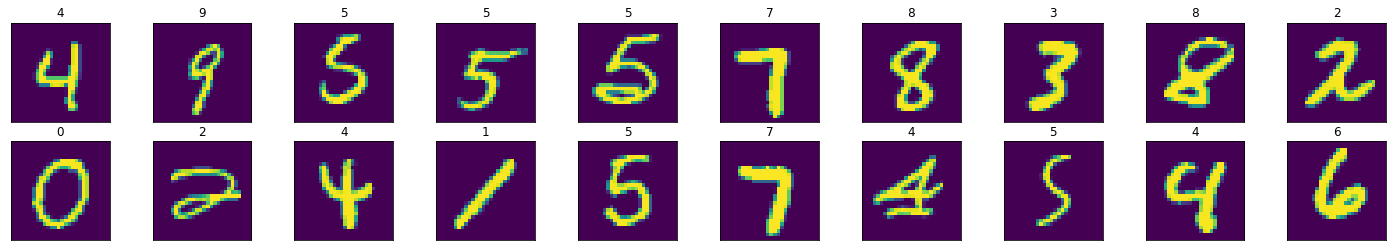

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(image_convert(images[idx]))
    ax.set_title(labels[idx].item())

In [ ]:
print(images.shape)
print(images.view(images.shape[0], -1).shape)
print(labels.size())
print(labels)

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100])
tensor([4, 9, 5, 5, 5, 7, 8, 3, 8, 2, 0, 2, 4, 1, 5, 7, 4, 5, 4, 6, 3, 6, 2, 8,
        9, 4, 5, 2, 2, 7, 3, 3, 1, 2, 0, 4, 6, 0, 3, 0, 0, 9, 2, 3, 3, 6, 3, 4,
        6, 0, 6, 9, 7, 2, 7, 2, 5, 6, 7, 1, 3, 2, 2, 8, 0, 3, 1, 3, 5, 7, 4, 0,
        3, 2, 3, 6, 8, 3, 3, 6, 6, 1, 9, 3, 2, 9, 5, 4, 0, 3, 2, 3, 1, 7, 5, 4,
        3, 4, 2, 9])


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # inputchannel, outputchannel(จำนวน featuremap น่าจะเท่ากับจำนวน kernel), ขนาด filter, stride 1ก็พอ ถ้ามากไปอาจจะไม่ดี
        self.conv2 = nn.Conv2d(20, 50, 5, 1) #  ตัวอย่างใช่ filter 5x5 เพราะงั้น HxW จะลดลงอย่างละ 4 จาก 28x28 เหลือ 24x24 เมื่อผ่าน conv1
        self.fc1 = nn.Linear(4*4*50, 500) # input layer 4*4*50 nodes, layer1 มี 500 nodes
        self.dropout1 = nn.Dropout(0.5) # ปกติวาง dropout ไว้ระหว่าง layer ที่จำนวน parameters เยอะๆ
        self.fc2 = nn.Linear(500, 10) # layer2(output) มี 10 nodes   
    def forward(self, x):
        x = F.relu(self.conv1(x)) #** รับ input ที่ต้องนี้แทนที่ __init__
        x = F.max_pool2d(x, 2, 2) # 2, 2 นี่คือขนาด kernel 2x2 in this case
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50) #-1 นี่น่าจะให้โปรแกรมมันใส่ batch size เอง/ 4*4*50 เนี่ยกลับไปดูที่ self.fc1 ก็น่าจะเดาได้ # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x) # จะได้เอาไปใส่ใน crossentropy / ได้ scores
        return x

In [ ]:
model = LeNet().to(device) # D_out ตาม class ที่เราจะ predict # ไอ .to() เนี่ยใส่ที model + tensor ที่เข้า model รวมถึงตอน predict แค่เพื่อให้เราใช้ GPU ได้เฉยๆ
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # complex dataset -> more efficient lr

In [ ]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for e in range(epochs):

    running_loss = 0.0
    running_correct = 0.0
    val_running_loss = 0.0
    val_running_correct = 0.0
    for inputs, labels in training_loader: #  ออกมาที 100 ภาพ 100 labels
        inputs = inputs.to(device)
        labels = labels.to(device)
        # inputs = inputs.view(inputs.shape[0], -1) #  -1 คือให้เป็น one long vector # พอมาใช้  CNN ไม่ต้องเปลี่ยนแล้ว ใส่ไปเป็นภาพได้เลย
        outputs = model(inputs) #  ใช้งานแบบนี้ได้เลย จริงไปอ่านมาว่าเราไม่ควรใช้ .forward / บรรทัดนี้ก็น่าจะออกมาเป็น tensor size=100
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1) # preds นี้คือ index ซึ่งสอดคล้องกับ ชื่อภาพ /  _ คือค่าmax แต่เราไม่ได้สนใจค่าเราสนใจ index ของมัน
        running_correct += torch.sum(preds == labels.data) # ตัวเศษของค่าเฉลี่ย
        running_loss += loss.item()
    else:
        with torch.no_grad(): # set requie_grad to False -> เพราะว่าเราไม่ได้จะ train model ใหม่ ทำแบบนี้จะช่วย save memory 
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1) #  -1 คือให้เป็น one long vector
                val_outputs = model(val_inputs) #  ใช้งานแบบนี้ได้เลย จริงไปอ่านมาว่าเราไม่ควรใช้ .forward / บรรทัดนี้ก็น่าจะออกมาเป็น tensor size=100
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1) 
                val_running_correct += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()

        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_correct.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_correct.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_acc)
        print("Epoch:", e+1)
        print("training loss: {:.4f}, acc:{:.4f}".format(epoch_loss, epoch_acc))
        print("validation loss: {:.4f}, val acc:{:.4f}".format(val_epoch_loss, val_epoch_acc))

Epoch: 1
training loss: 0.5902, acc:83.8167
validation loss: 0.1912, val acc:94.2500
Epoch: 2
training loss: 0.1535, acc:95.4867
validation loss: 0.1082, val acc:96.7600
Epoch: 3
training loss: 0.1014, acc:96.9633
validation loss: 0.0825, val acc:97.4000
Epoch: 4
training loss: 0.0795, acc:97.6533
validation loss: 0.0638, val acc:98.1300
Epoch: 5
training loss: 0.0672, acc:97.9300
validation loss: 0.0557, val acc:98.2000
Epoch: 6
training loss: 0.0572, acc:98.2367
validation loss: 0.0477, val acc:98.4500
Epoch: 7
training loss: 0.0516, acc:98.4300
validation loss: 0.0439, val acc:98.5000
Epoch: 8
training loss: 0.0465, acc:98.5800
validation loss: 0.0388, val acc:98.7900
Epoch: 9
training loss: 0.0415, acc:98.7333
validation loss: 0.0368, val acc:98.8900
Epoch: 10
training loss: 0.0377, acc:98.8333
validation loss: 0.0379, val acc:98.7700
Epoch: 11
training loss: 0.0344, acc:98.9533
validation loss: 0.0341, val acc:98.9100
Epoch: 12
training loss: 0.0326, acc:99.0100
validation loss: 0

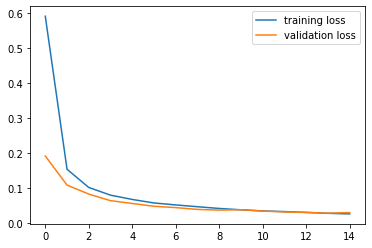

In [ ]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()
plt.show()

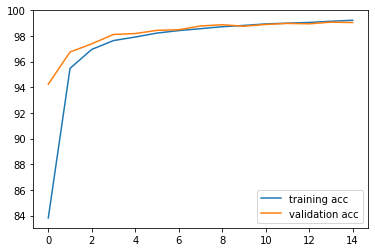

In [ ]:
plt.plot(running_correct_history, label="training acc")
plt.plot(val_running_correct_history, label="validation acc")
plt.legend()
plt.show()

In [ ]:
# print(len(training_loader))
# print(len(validation_loader))

# print(training_dataset)
# print(validation_dataset)
# print(type(len(training_dataset)))
# print(len(validation_dataset))

<Response [200]>
format: JPEG


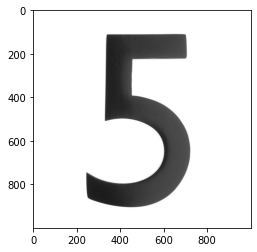

In [ ]:
import requests
from PIL import Image, ImageOps
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream=True)
print(response)

img = Image.open(response.raw)
print("format:", img.format)
plt.imshow(img)

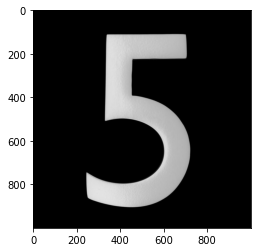

In [ ]:
img = ImageOps.invert(img)
plt.imshow(img)

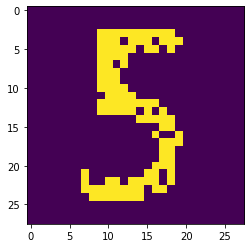

In [ ]:
img = img.convert("1") # convert to binary image
img = transform(img)
plt.imshow(image_convert(img))

In [ ]:
# img.shape
# img
print("shape of img:", img.shape)

shape of img: torch.Size([1, 28, 28])


In [ ]:
img = img.to(device)
img = img[0].unsqueeze(0).unsqueeze(0) # unsqueeze ใส่เลข 1 ลงไปใน dimension ที่เรา specified
print("shape of img now:", img.shape)
output = model(img)
_, pred = torch.max(output, 1)
print(pred) # ทายได้ผล

shape of img now: torch.Size([1, 1, 28, 28])
tensor([5], device='cuda:0')


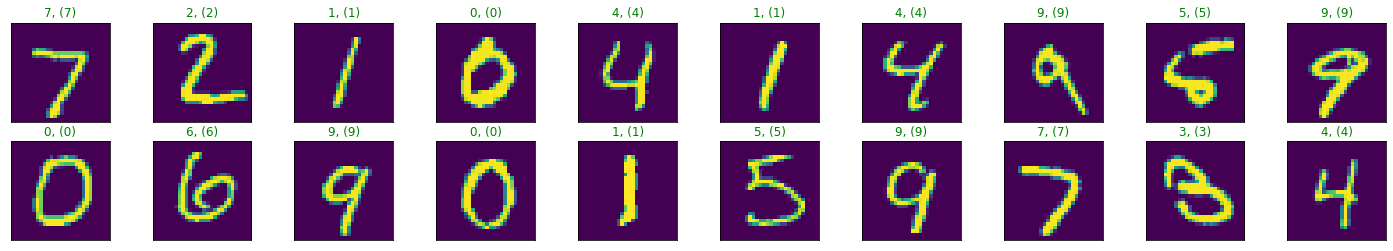

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, pred = torch.max(output, 1)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(image_convert(images[idx]))
    ax.set_title("{}, ({})".format(str(pred[idx].item()), str(labels[idx].item())), color=("green" if pred[idx] == labels[idx] else "red"))